In [1]:
#After pip install opencv-python
import cv2
from tqdm import tqdm

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
from sklearn.metrics import roc_auc_score

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

import tensorflow as tf
print("Tensorflow is installed and is version: ",  tf.__version__)

Tensorflow is installed and is version:  1.3.0


In [3]:
df = pd.read_csv('labels.csv/labels.csv')
df.head()
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

### We choose the width to be 96 which will generate 27,648 (96 x 96 x 3) variables. We originally chose a width of 256 for higher precision. However, with 10,222 sample images, we were creating a pickle file greater than 4GB, which was having trouble being loaded into memory. We also had problems loading the training data into tensorflow, getting an error "Graphdef cannot be larger than 2GB". So 96 width was roughly the maximum precision we could use given our platform constraints (after testing the 126 width without being able to work with it in AWS given the current limits and capacities). 

In [4]:
width = 96

In [5]:
data = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    data[i] = cv2.resize(cv2.imread('train/train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1


100%|███████████████████████████████████| 10222/10222 [01:12<00:00, 141.73it/s]


In [7]:
df2 = pd.read_csv('sample_submission.csv')
n_test = len(df2)
test_data = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    test_data[i] = cv2.resize(cv2.imread('test/test/%s.jpg' % df2['id'][i]), (width, width))

100%|███████████████████████████████████| 10357/10357 [00:53<00:00, 192.38it/s]


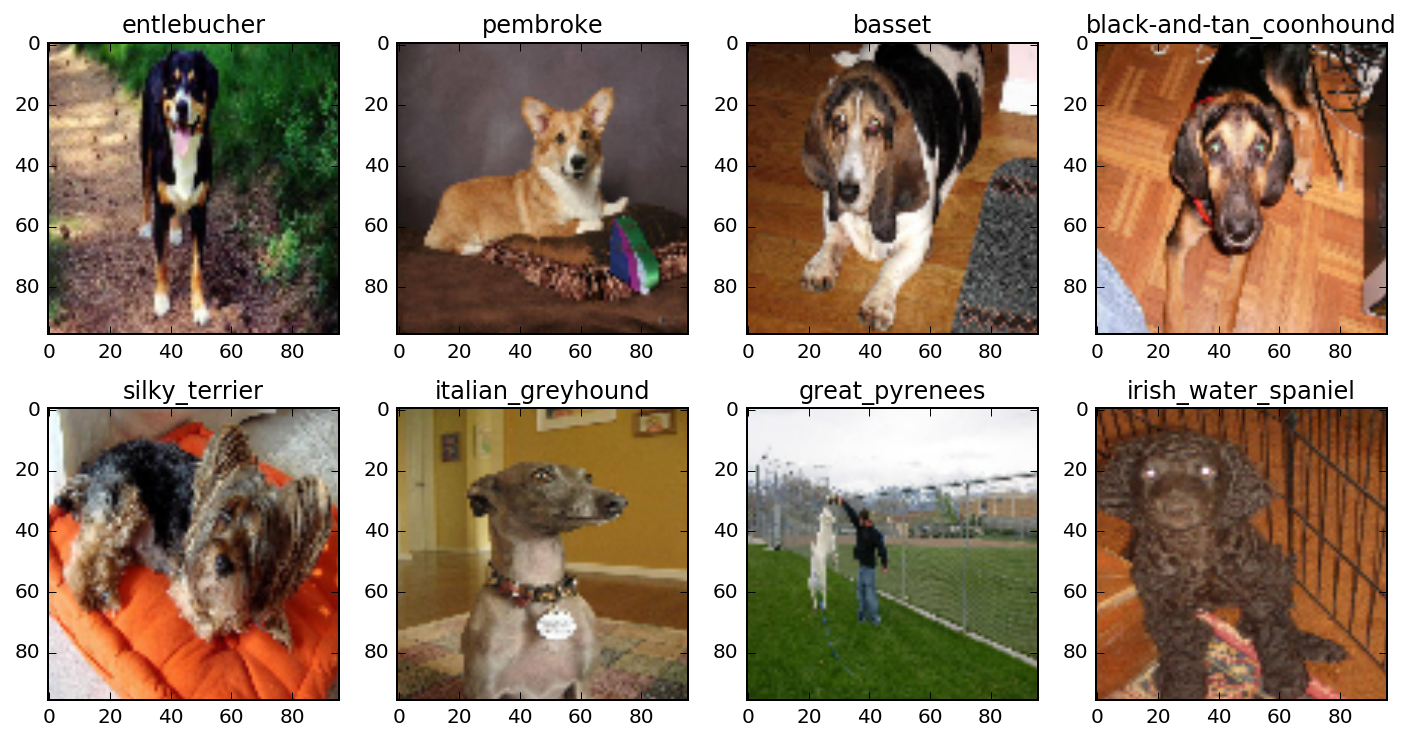

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(data[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

In [9]:
pickle_file = 'SVHN_HW4.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'data': data,
        'labels': y,
        'test_data': test_data
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 570195125


In [10]:
pickle_file = 'SVHN_HW4.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    data = save['data']
    y = save['labels']
    test_data=save['test_data']
    del save  # to free up memory
    
    print('Training set', data.shape, y.shape)

Training set (10222, 96, 96, 3) (10222, 120)


### We chose simple normalization, after investigating LCN (LeCun) normalization and other scaling methods. In addition to Dave suggestion during the section that this is mainly used and if we use more sofisticated narmalization, a minimal increase in accuracy will be shown

In [11]:
normalize_simple = lambda dataset: ((dataset / 255.0) - 0.5)

data1 = normalize_simple(data)
test_data = normalize_simple(test_data)

In [12]:
data1.shape

(10222, 96, 96, 3)

### After some deliberation, we chose a validation size of 1500, or roughly 15% of the training set. We would like to keep as much data as we can to build the model.

### Our plan is to use the validation set to choose hyperparameters then run the model on the whole data. To do that using cross validation, we will manually set up a discrete multi-loop over all parameters and run the model for each combination then choose the best.

In [13]:
#Splitting the data into training and validation
from sklearn.model_selection import train_test_split
train_data, valid_data, train_labels, valid_labels = train_test_split(data1, y, test_size=1500)

In [14]:
valid_data.shape

(1500, 96, 96, 3)

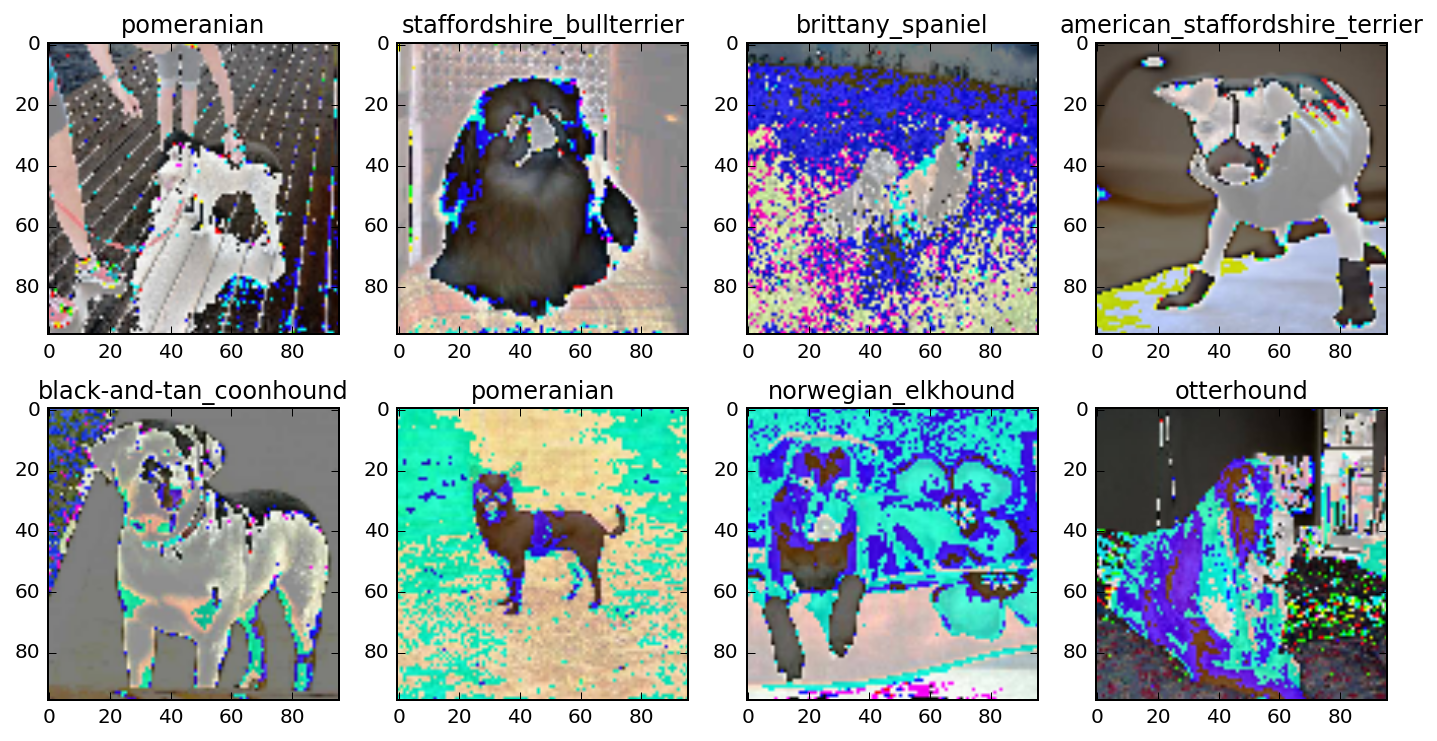

In [15]:
# viewing some of the scaled training data with labels
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, 300)
    plt.subplot(2, 4, i+1)
    plt.imshow(train_data[random_index][:,:,::-1])
    plt.title(num_to_class[valid_labels[random_index].argmax()])

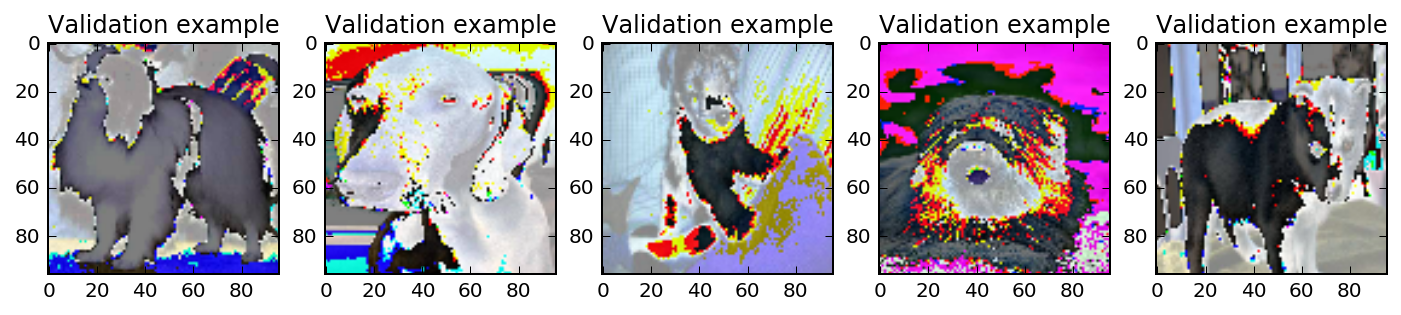

In [16]:
# viewing some of the scaled validation data
import matplotlib.image as mpimg
plt.ion()
fig1 = plt.figure(figsize=(12, 12))
for k in range(5):
    i = np.random.choice(range(len(valid_data)))
    imgplot1 = fig1.add_subplot(3,5,k+1)
    imgplot1.imshow(valid_data[i, :, :], cmap='gray')    
    imgplot1.set_title("Validation example", fontsize=12)
    
plt.show()

# Feed Forward Neural network using TensorFlow

## Multi-layer (4) feed-forward neural network

### We will transform each image to one row containing data about it, which means 96x96x3 columns. We aim below to buit a full 4 layers (i.e. 2 hidden layers without the input and output ones) neural network model similar to the one presented in the course and section with relu activation function to facilitate the estimation of weights. We added a regularization while lowering its weight to allow for larger estimation but limit the overfit to some extent. 

In [17]:
sigmoid = lambda t: 1 / (1 + np.exp(-t))
tanh = lambda t: (np.exp(t) - np.exp(-t)) / (np.exp(t) + np.exp(-t))
relu = lambda t:  np.maximum(t,0.)
softmax = lambda t: np.exp(t) / np.sum((1 + np.exp(t)), axis=0)

In [18]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape, name):
    #initial = tf.truncated_normal(shape, stddev=0.01)
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    #initial = tf.constant(0.1, shape=shape)
    initial = tf.zeros(shape)
    return tf.Variable(initial, name)

split_by_half = lambda x,k : int(x/2**k)

In [19]:
batch_size = 256
flattened_size = train_data.reshape((-1, width * width*3)).astype(np.float32).shape[1]
hidden_nodes = 1024
lamb_reg = 0.0001

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, flattened_size), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, shape=(batch_size, 120), name="TrainingLabels")
    tf_valid_dataset = tf.constant(valid_data.reshape((-1, width * width*3)).astype(np.float32), name="ValidationData")
    tf_test_dataset = tf.constant(test_data.reshape((-1, width * width*3)).astype(np.float32), name="TestingData")

    # Variables.
    layer1_weights = weight_variable([flattened_size, hidden_nodes], name="weights1")
    layer1_biases = bias_variable([hidden_nodes], name="biases1")
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)], name="weights2")
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)], name="biases2")
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)], name="weights3")
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)], name="biases3")
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), 120], name="weights4")
    layer4_biases = bias_variable([120], name="biases4")
        
    keep_prob = tf.placeholder("float", name="keep_prob")
    
    def model(data, name, proba=keep_prob):
        with tf.name_scope(name) as scope:
            layer1 = tf.add(tf.matmul(data, layer1_weights), layer1_biases, name="layer1")
            hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba, name="dropout1")   # dropout on the hidden layer
            layer2 = tf.add(tf.matmul(hidden1, layer2_weights), layer2_biases, name="layer2")  # a new hidden layer
            hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba, name="dropout2")
            layer3 = tf.add(tf.matmul(hidden2, layer3_weights), layer3_biases, name="layer3")
            hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
            layer4 = tf.add(tf.matmul(hidden3, layer4_weights), layer4_biases, name="layer4")
            return layer4
    
    # Training computation.
    logits = model(tf_train_dataset, "logits", keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labelset), name="loss")
    # We have more weights and biases to regularize
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) +
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) +
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) +
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    loss += lamb_reg * regularizers
    #loss = tf.reduce_mean(loss + lamb_reg * regularizers)
    
    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0, name="globalstep")  # count  number of steps taken.
    start_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.97, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, "validation", 1.0))  # no dropout
    test_prediction = tf.nn.softmax(model(tf_test_dataset, "testing", 1.0))  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

### Running 5,000 epochs of the 4-layer feed forward model achieved ~65% accuracy in the min-batch sample, but only ~6% accuracy in the validation sample. The test dataset also performed poorly on Kaggle. Please see attached screenshots for details.

In [27]:
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run() 
        loss_summary = tf.summary.scalar('Loss', loss)
        learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
        merged = tf.summary.merge_all()  
        writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
        print("Initialized\n")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_data.reshape((-1, width * width*3)).astype(np.float32)[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
            writer.add_summary(learning_rate_summary.eval(), epoch)
            if (epoch % 100 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                print("Validation accuracy: {:.1f}\n".format(accuracy(valid_prediction.eval(), valid_labels)))
        #print("Test accuracy: {:.1f}\n".format(accuracy(test_prediction.eval(), test_labelset)))
        #test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
        #save_path = saver.save(session, "tmp/tensorflowmodels/" + name +".ckpt")
        #print("Model saved in file: %s" % save_path)
        
run_session(100, "Drop_NN", 0.5)

Initialized

Minibatch loss at epoch 0: 5.1023454666137695
Minibatch accuracy: 0.8
Validation accuracy: 1.1



### Attached to this notebook, you can find results of the 5000 epoch. They are not included here since we did several testing and due to some problems and cost related, we are not running it again and you can find results in the screen shot attached.

## Convolutional Neural Network (CNN)

### After much trial and error, we set the hyper parameters of the CNN as follows. A batch size of 256 was necessary to capture the finer details of the images, too large a batch size would lack accuracy. A filter size of 5 was selected for the same reason. We kept the depth as presented in section with 32 and 64 filters respectively. Pooling was kept similar to what was presented in Section. We chose a small learning rate, experiments wih larger learning rates led to poor accuracy. Dropout was kept at 0.5 to avoid over-fitting.

In [19]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=1e-4)
    #initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.zeros(shape)
    #initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [30]:
height = 96
width = 96
channels = 3
num_labels = 120

valid_batch_size = 1500
test_batch_size = 1
batch_size = 256
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024
lamb_reg = 0.0001
learning_rate = 0.01  #  learning rate for the momentum optimizer

reset_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    tf_test_dataset = tf.placeholder(tf.float32,
                                     shape=(test_batch_size, height, width, channels), name="TestingData")

    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Variables 
    layer1_weights = weight_variable([patch_size, patch_size, channels, depth1], name="weights1")
    layer1_biases = bias_variable([depth1], name="biases1")
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2], name="weights2")
    layer2_biases = bias_variable([depth2], name="biases2")    
    layer3_weights = weight_variable([height // 4 * width // 4 * depth2, num_hidden], name="weights3")
    layer3_biases = bias_variable([num_hidden], name="biases3")    # Model with dropout
    layer4_weights = weight_variable([num_hidden, num_labels], name="weights4")
    layer4_biases = bias_variable([num_labels], name="biases4")
            
    def model(data, name, proba=keep_prob):
            # Model.
            #inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
            inputs = tf.cast(data,dtype=tf.float32)
            #inputs = LeCunLCN(data, data.get_shape().as_list())
            # Convolution
            conv_1 = tf.nn.bias_add(tf.nn.conv2d(inputs, layer1_weights, [1, 1, 1, 1], padding='SAME'), layer1_biases, name="layer1")
            pool_1 = tf.nn.max_pool(tf.nn.relu(conv_1), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled1")
            # Convolution
            conv_2 = tf.nn.bias_add(tf.nn.conv2d(pool_1, layer2_weights, [1, 1, 1, 1], padding='SAME'), layer2_biases, name="layer2")
            pool_2 = tf.nn.max_pool(tf.nn.relu(conv_2), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled2")
            # Fully Connected Layer
            shape = pool_2.get_shape().as_list()
            #print (shape)
            reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
            full_3 = tf.nn.relu(tf.nn.bias_add(tf.matmul(reshape, layer3_weights),layer3_biases))
            
            # Dropout
            full_4 = tf.nn.dropout(full_3, proba)
            print(full_4.get_shape().as_list())
            layer_fc = tf.nn.bias_add(tf.matmul(full_4, layer4_weights),layer4_biases, name="layer_fc")
            return layer_fc
  
   # Training computation.
    logits = model(tf_train_dataset, "logits", keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labelset), name="loss")
    #regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) +
    #                tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) +
    #                tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) +
    #                tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    #loss = tf.reduce_mean(loss + lamb_reg * regularizers)
    
    # Optimizer
    #global_step = tf.Variable(0, name="globalstep")  # count  number of steps taken.
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, "validation", 1.0))  # no dropout
    test_prediction = tf.nn.softmax(model(tf_test_dataset, "testing", 1.0))  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[256, 1024]
[1500, 1024]
[1, 1024]


In [31]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, k_prob=1.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(train_labels.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_data[offset:(offset + batch_size)]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : k_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 2) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            feed_dict = {tf_valid_dataset : batch_valid_data}
                            predictions = session.run(valid_prediction, feed_dict) 
                            true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            save_path = saver.save(session, "tmp/tensorflowmodels/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)

### Running 250 epochs of the CNN model produced accuracy in the min-batch of ~67%, but only ~4% in the validation sample (see attached screenshots). The test dataset also performed poorly in Kaggle.

In [34]:
run_session(100, "LeNet_CNN_96", 0.5)

Initialized

Minibatch loss at epoch 2: 4.786931037902832
Minibatch accuracy: 0.8
Validation accuracy: 1.1

Minibatch loss at epoch 4: 4.6727614402771
Minibatch accuracy: 2.0
Validation accuracy: 1.7

Minibatch loss at epoch 6: 4.541231632232666
Minibatch accuracy: 1.2
Validation accuracy: 2.3

Minibatch loss at epoch 8: 4.527990818023682
Minibatch accuracy: 2.3
Validation accuracy: 3.1

Minibatch loss at epoch 10: 4.516973495483398
Minibatch accuracy: 3.1
Validation accuracy: 2.9

Minibatch loss at epoch 12: 4.417704105377197
Minibatch accuracy: 3.9
Validation accuracy: 3.3

Minibatch loss at epoch 14: 4.334744453430176
Minibatch accuracy: 5.9
Validation accuracy: 3.6

Minibatch loss at epoch 16: 4.2706522941589355
Minibatch accuracy: 5.9
Validation accuracy: 3.9

Minibatch loss at epoch 18: 4.165574550628662
Minibatch accuracy: 7.4
Validation accuracy: 3.4

Minibatch loss at epoch 20: 4.0333404541015625
Minibatch accuracy: 8.6
Validation accuracy: 3.7

Minibatch loss at epoch 22: 4.0

In [40]:
predictions=[]
with tf.Session(graph=graph) as session:
    ckpt = tf.train.get_checkpoint_state('tmp/tensorflowmodels/')
    saver.restore(session, ckpt.model_checkpoint_path)
    for batch_num in range(int(test_data.shape[0])): 
        batch_test_data = test_data[batch_num:(batch_num+1)]
        feed_dict = {tf_test_dataset : batch_test_data}
        predictions = np.append(predictions,session.run(test_prediction, feed_dict))
    predictions1=predictions.reshape(10357,120)
    pred=pd.DataFrame(predictions1)

INFO:tensorflow:Restoring parameters from tmp/tensorflowmodels/LeNet_CNN_96.ckpt


In [41]:
submission = pd.read_csv("sample_submission.csv",sep=",")
pred.columns=submission.columns[1:]
pred.insert(0, "id", submission['id'])
#pred_sort = pred[sorted(pred.columns)]
pred.to_csv("cnn3.csv", index=None)

# CNN based on LeNet-5

### The below is the LeNet-5 architecture estimated on the data followed by Tensor flow architecture explained in section. It is performing better than traditional neural network but it is not a good prediction.

In [20]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=1e-4)
    #initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.zeros(shape)
    #initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
normalize_simple = lambda dataset: ((dataset / 255.0) - 0.5)

In [26]:
height = 96
width = 96
channels = 3
num_labels = 120

valid_batch_size = 1500
test_batch_size = 1
batch_size = 1024
patch_size = 5
depth1 = 32
depth2 =64
num_hidden = 1024
lamb_reg = 0.01
learning_rate = 0.01  #  learning rate for the momentum optimizer

reset_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    tf_test_dataset = tf.placeholder(tf.float32,
                                     shape=(test_batch_size, height, width, channels), name="TestingData")

    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Variables 
    layer1_weights = weight_variable([patch_size, patch_size, channels, depth1], name="weights1")
    layer1_biases = bias_variable([depth1], name="biases1")
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2], name="weights2")
    layer2_biases = bias_variable([depth2], name="biases2")    
    layer3_weights = weight_variable([height // 4 * width // 4 * depth2, num_hidden], name="weights3")
    layer3_biases = bias_variable([num_hidden], name="biases3")    # Model with dropout
    layer4_weights = weight_variable([num_hidden, num_labels], name="weights4")
    layer4_biases = bias_variable([num_labels], name="biases4")
            
    def model(data, name, proba=keep_prob):
            # Model.
            inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
            #inputs = tf.cast(data,dtype=tf.float32)
            #inputs = LeCunLCN(data, data.get_shape().as_list())
            # Convolution
            conv_1 = tf.nn.bias_add(tf.nn.conv2d(inputs, layer1_weights, [1, 1, 1, 1], padding='SAME'), layer1_biases, name="layer1")
            pool_1 = tf.nn.max_pool(tf.nn.relu(conv_1), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled1")
            # Convolution
            conv_2 = tf.nn.bias_add(tf.nn.conv2d(pool_1, layer2_weights, [1, 1, 1, 1], padding='SAME'), layer2_biases, name="layer2")
            pool_2 = tf.nn.max_pool(tf.nn.relu(conv_2), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled2")
            # Fully Connected Layer
            shape = pool_2.get_shape().as_list()
            #print (shape)
            reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
            full_3 = tf.nn.relu(tf.nn.bias_add(tf.matmul(reshape, layer3_weights),layer3_biases))
            
            # Dropout
            full_4 = tf.nn.dropout(full_3, proba)
            print(full_4.get_shape().as_list())
            layer_fc = tf.nn.bias_add(tf.matmul(full_4, layer4_weights),layer4_biases, name="layer_fc")
            return layer_fc
  
   # Training computation.
    logits = model(tf_train_dataset, "logits", keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labelset), name="loss")
    #regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) +
    #                tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) +
    #                tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) +
    #                tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    #loss = tf.reduce_mean(loss + lamb_reg * regularizers)
    
    # Optimizer
    #global_step = tf.Variable(0, name="globalstep")  # count  number of steps taken.
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, "validation", 1.0))  # no dropout
    test_prediction = tf.nn.softmax(model(tf_test_dataset, "testing", 1.0))  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[1024, 1024]
[1500, 1024]
[1, 1024]


In [27]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, k_prob=1.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(train_labels.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_data[offset:(offset + batch_size)]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : k_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 1) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            feed_dict = {tf_valid_dataset : batch_valid_data}
                            predictions = session.run(valid_prediction, feed_dict) 
                            true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            #save_path = saver.save(session, "tmp/tensorflowmodels/" + name +".ckpt")
            #print("Model saved in file: %s" % save_path)
  

### We ran tensorflow models both on our local machines and on AWS. On AWS we were able to increase the number of epochs, use smaller batch sizes, and use lower learning rates to increase accuracy. We recently experienced problems with our AWS account, so the following example was run locally. However we have run this same example on AWS using 100 epochs, 256 batch size and .0001 learning rate. It did not improve our Kaggle score however. The example below uses only 5 epochs due to laptop slowness.

In [28]:
run_session(5, "LeNet_CNN", 0.5)

Initialized

Minibatch loss at epoch 1: 4.787485122680664
Minibatch accuracy: 1.2
Validation accuracy: 0.8

Minibatch loss at epoch 2: 4.78739595413208
Minibatch accuracy: 1.5
Validation accuracy: 1.5

Minibatch loss at epoch 3: 4.7873077392578125
Minibatch accuracy: 1.4
Validation accuracy: 1.5

Minibatch loss at epoch 4: 4.786064147949219
Minibatch accuracy: 1.4
Validation accuracy: 1.5

Minibatch loss at epoch 5: 4.773821830749512
Minibatch accuracy: 1.4
Validation accuracy: 1.5

Minibatch loss at epoch 6: 4.777509689331055
Minibatch accuracy: 1.3
Validation accuracy: 1.5



In [16]:
predictions=[]
with tf.Session(graph=graph) as session:
    ckpt = tf.train.get_checkpoint_state('tmp/tensorflowmodels/')
    saver.restore(session, ckpt.model_checkpoint_path)
    for batch_num in range(int(test_data.shape[0])): 
        batch_test_data = test_data[batch_num:(batch_num+1)]
        feed_dict = {tf_test_dataset : batch_test_data}
        predictions = np.append(predictions,session.run(test_prediction, feed_dict))
    predictions1=predictions.reshape(10357,120)
    pred=pd.DataFrame(predictions1)

INFO:tensorflow:Restoring parameters from tmp/tensorflowmodels/LeNet_CNN.ckpt


In [29]:
dfpred = pred
col_names = sorted(list(num_to_class.items()),key=lambda x:x[0])
dfpred.columns  = list(zip(*col_names))[1]
dfpred.index = test_ids
dfpred.index.names = ['id']
dfpred = dfpred[sorted(dfpred.columns)]
dfpred.to_csv('cnn_alt.csv')

# Using Tensorflow tf.layers

In [21]:
height = 96
width = 96
channels = 3
num_labels = 120
learning_rate = 0.001

valid_batch_size = 5000
test_batch_size = 1
batch_size = 256

## ///// Model definition of parameters
conv1_fmaps = 32
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 5
conv2_stride = 1
conv2_pad = "SAME"

num_fcl1 = 1024

reset_graph()

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    tf_test_dataset = tf.placeholder(tf.float32,
                                     shape=(test_batch_size, height, width, channels), name="TestingData")

    # !!! we change this to dropout probability 1 - keep_prob
    # tf.layers.dropout uses dropout proability - i.e. 0.8 means 80% will be dropped
    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        #with tf.variable_scope("model") as scope:
            #inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
            inputs = tf.cast(data,dtype=tf.float32)
            #inputs = LeCunLCN(data, data.get_shape().as_list())     
            with tf.variable_scope("layer1") as scope:
                # Convolution
                conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                          strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
                # Max pooling
                pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=[2, 2], strides=2)

            with tf.variable_scope("layer2") as scope:
                conv_2 = tf.layers.conv2d(inputs=pool_1, filters=conv2_fmaps, kernel_size=conv2_ksize, 
                                          strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
                pool_2 = tf.layers.max_pooling2d(conv_2, [2, 2], 2)

            with tf.variable_scope("layer3") as scope:
                print(pool_2.get_shape().as_list())
                pool2_flat = tf.reshape(pool_2, [-1, height // 4 * width // 4 * conv2_fmaps])
                full_3 = tf.layers.dense(inputs=pool2_flat, units=num_fcl1, activation=tf.nn.relu)
                
            with tf.variable_scope("layer4") as scope:
                dropout = tf.layers.dropout(full_3, rate=drop_prob, training=training)
                full_4 = tf.layers.dense(inputs=dropout, units=num_labels)

            return full_4
        
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labelset))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    with tf.variable_scope("model", reuse=True):   
        #scope.reuse_variables()
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    with tf.variable_scope("model", reuse=True):   
        #scope.reuse_variables()
        test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[256, 24, 24, 64]
[5000, 24, 24, 64]
[1, 24, 24, 64]


In [22]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, d_prob=0.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(train_labels.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_data[offset:(offset + batch_size)]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, drop_prob : d_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 1) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            feed_dict = {tf_valid_dataset : batch_valid_data, drop_prob : d_prob}
                            predictions = session.run(valid_prediction, feed_dict) 
                            true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))
                        for batch_num in range(int(test_data.shape[0]/test_batch_size)): 
                            batch_test_data = test_data[batch_num*test_batch_size:(batch_num+1)*test_batch_size]
                            feed_dict = {tf_test_dataset : batch_test_data, drop_prob : 0.5}
                            predictions_test = session.run(test_prediction, feed_dict)

            save_path = saver.save(session, "/tmp/tensorflowmodels/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)

            

In [23]:
run_session(10, "LeNet_CNN_Alt", 0.5)

Initialized

Minibatch loss at epoch 1: 133.52133178710938
Minibatch accuracy: 0.4
Validation accuracy: 0.0

Minibatch loss at epoch 2: 4.7936177253723145
Minibatch accuracy: 0.4
Validation accuracy: 0.0

Minibatch loss at epoch 3: 4.78559684753418
Minibatch accuracy: 0.8
Validation accuracy: 0.0

Minibatch loss at epoch 4: 4.780758857727051
Minibatch accuracy: 1.6
Validation accuracy: 0.0

Minibatch loss at epoch 5: 4.793180465698242
Minibatch accuracy: 1.2
Validation accuracy: 0.0



KeyboardInterrupt: 

In [18]:
with tf.Session(graph=graph) as session:
    ckpt = tf.train.get_checkpoint_state('/tmp/tensorflowmodels/')
    saver.restore(session, ckpt.model_checkpoint_path)
    for batch_num in range(int(test_data.shape[0]/test_batch_size)): 
        batch_test_data = test_data[batch_num*test_batch_size:(batch_num+1)*test_batch_size]
        feed_dict = {tf_test_dataset : batch_test_data, drop_prob : 1.0}
        predictions = session.run(test_prediction, feed_dict) 

INFO:tensorflow:Restoring parameters from /tmp/tensorflowmodels/LeNet_CNN_Alt.ckpt


In [ ]:
predictions.shape

# The AlexNet Deep Learning architecture

In [9]:
height = 96
width = 96
channels = 3
num_labels = 120
learning_rate = 0.01 

valid_batch_size = 5000
test_batch_size = 6508
#batch_size = 256
batch_size = 500

## ///// Model definition of parameters
conv1_fmaps = 64
conv1_ksize = [11,11]
conv1_stride = 3
conv1_pad = "SAME"
pool1_ksize = [3,3]
pool1_stride = 1

conv2_fmaps = 128
conv2_ksize = [7,7]
conv2_stride = 1
conv2_pad = "SAME"
pool2_ksize = [3,3]
pool2_stride = 2

conv3_fmaps = 256
conv3_ksize = [7,7]
conv3_stride = 2
conv3_pad = "SAME"
pool3_ksize = [3,3]
pool3_stride = 2

num_fcl1 = 1024
num_fcl2 = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    #tf_test_dataset = tf.placeholder(tf.float32,
     #                                shape=(test_batch_size, height, width, channels), name="TestingData")
    
    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
        #inputs = tf.cast(data,dtype=tf.float32)
        #inputs = LeCunLCN(data, data.get_shape().as_list())
        with tf.variable_scope("layer1") as scope:
            # Convolution
            conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                      strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
            # Max pooling
            pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=pool1_ksize, strides=pool1_stride)
            # Normalization and dropout
            norm_1 = tf.nn.lrn(pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_1 = tf.layers.dropout(norm_1, rate=drop_prob, training=training)

        with tf.variable_scope("layer2") as scope:
            conv_2 = tf.layers.conv2d(inputs=drop_1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                      strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
            pool_2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=pool2_ksize, strides=pool2_stride)
            norm_2 = tf.nn.lrn(pool_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_2 = tf.layers.dropout(norm_2, rate=drop_prob, training=training)

        with tf.variable_scope("layer3") as scope:
            conv_3 = tf.layers.conv2d(inputs=drop_2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                                      strides=conv3_stride, padding=conv3_pad, activation=tf.nn.relu)
            pool_3 = tf.layers.max_pooling2d(inputs=conv_3, pool_size=pool3_ksize, strides=pool3_stride)
            norm_3 = tf.nn.lrn(pool_3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_3 = tf.layers.dropout(norm_3, rate=drop_prob, training=training)

        with tf.variable_scope("layer4") as scope:
            print(pool_1.get_shape().as_list())
            print(conv_1.get_shape().as_list())
            print(pool_2.get_shape().as_list())
            print(conv_2.get_shape().as_list())
            print(pool_3.get_shape().as_list())
            print(conv_3.get_shape().as_list())
            reshape_flat = tf.reshape(drop_3, [-1, 3*3*conv3_fmaps])
            full_4 = tf.layers.dense(inputs=reshape_flat, units=num_fcl1, activation=tf.nn.relu)

        with tf.variable_scope("layer5") as scope:
            full_5 = tf.layers.dense(inputs=full_4, units=num_fcl2, activation=tf.nn.relu)

        with tf.variable_scope("layer6") as scope:
            full_6 = tf.layers.dense(inputs=full_5, units=num_labels)

        return full_6
    
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        print(logits.get_shape().as_list())
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labelset))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    with tf.variable_scope("model", reuse=True):   
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    #with tf.variable_scope("model", reuse=True):   
    #    test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[500, 30, 30, 64]
[500, 32, 32, 64]
[500, 14, 14, 128]
[500, 30, 30, 128]
[500, 3, 3, 256]
[500, 7, 7, 256]
[500, 120]
[5000, 30, 30, 64]
[5000, 32, 32, 64]
[5000, 14, 14, 128]
[5000, 30, 30, 128]
[5000, 3, 3, 256]
[5000, 7, 7, 256]


In [10]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, d_prob=0.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(train_labels.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_data[offset:(offset + batch_size)]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, drop_prob : d_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 1) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            feed_dict = {tf_valid_dataset : batch_valid_data, drop_prob : d_prob}
                            predictions = session.run(valid_prediction, feed_dict) 
                            true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            save_path = saver.save(session, "tmp/tensorflowmodels/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)

### Our Alex Net example had poor accuracy results, even after 100 epochs. If we had more time and more resources available on AWS, we would re-run this example using a lower learning rate, as it is possible the gradient descent was not optimizing correctly.

In [12]:
run_session(250, "AlexNet_NN", 0.2)

Initialized

Minibatch loss at epoch 1: 4.793115615844727
Minibatch accuracy: 0.8
Validation accuracy: 0.0

Minibatch loss at epoch 2: 4.775002956390381
Minibatch accuracy: 1.4
Validation accuracy: 0.0

Minibatch loss at epoch 3: 4.777181625366211
Minibatch accuracy: 0.8
Validation accuracy: 0.0

Minibatch loss at epoch 4: 4.77839469909668
Minibatch accuracy: 1.0
Validation accuracy: 0.0

Minibatch loss at epoch 5: 4.775880336761475
Minibatch accuracy: 1.2
Validation accuracy: 0.0

Minibatch loss at epoch 6: 4.772940158843994
Minibatch accuracy: 1.0
Validation accuracy: 0.0

Minibatch loss at epoch 7: 4.777490615844727
Minibatch accuracy: 1.0
Validation accuracy: 0.0

Minibatch loss at epoch 8: 4.776556015014648
Minibatch accuracy: 0.8
Validation accuracy: 0.0

Minibatch loss at epoch 9: 4.778094291687012
Minibatch accuracy: 1.0
Validation accuracy: 0.0

Minibatch loss at epoch 10: 4.780981540679932
Minibatch accuracy: 1.0
Validation accuracy: 0.0

Minibatch loss at epoch 11: 4.7756924

KeyboardInterrupt: 

### You can see some erros above due to AWS issues faced with storage capacity and limits issues. That AWS causes a lot a of problems especially that we didn't have time to setup better and test its performance. We are a team of two but only 1 user has an account with limit to run the above due to authorization problems.

#  New Architecture based on AlexNet

### We are trying below to do 120 seperate AlexNet CNN for each dog breed alone, then aggregate all models toghether and choose a prediction for each picture on the testing sample from the net that gives the highest probability. We don't know the importance of the above architecture based on AlexNet architecture but we are pretty sure that with more data than here where you are able to have more dogs breed (lets say at least 1000 pictures for each dog breed), these ensemble of models will produce better prediction accuracy than one single Net; The idea is that each dog breed identification network will have its special weights in the last 3 full layers which optimize the performance and can be considered also from another point of view as ensemble of models which usually outperform single model.

### Unfortunately, we are going out of resources and facing some problems on AWS, in addition to time limitations, the above with AWS limit increase problems consumed a lot of time.

In [63]:
height = 96
width = 96
channels = 3

valid_batch_size = 5000
test_batch_size = 6508
#batch_size = 256
batch_size = 500

## ///// Model definition of parameters
conv1_fmaps = 64
conv1_ksize = [11,11]
conv1_stride = 3
conv1_pad = "SAME"
pool1_ksize = [3,3]
pool1_stride = 1

conv2_fmaps = 128
conv2_ksize = [7,7]
conv2_stride = 1
conv2_pad = "SAME"
pool2_ksize = [3,3]
pool2_stride = 2

conv3_fmaps = 256
conv3_ksize = [7,7]
conv3_stride = 2
conv3_pad = "SAME"
pool3_ksize = [3,3]
pool3_stride = 2

num_fcl1 = 1024
num_fcl2 = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    #tf_test_dataset = tf.placeholder(tf.float32,
     #                                shape=(test_batch_size, height, width, channels), name="TestingData")
    
    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
        #inputs = tf.cast(data,dtype=tf.float32)
        #inputs = LeCunLCN(data, data.get_shape().as_list())
        with tf.variable_scope("layer1") as scope:
            # Convolution
            conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                      strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
            # Max pooling
            pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=pool1_ksize, strides=pool1_stride)
            # Normalization and dropout
            norm_1 = tf.nn.lrn(pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_1 = tf.layers.dropout(norm_1, rate=drop_prob, training=training)

        with tf.variable_scope("layer2") as scope:
            conv_2 = tf.layers.conv2d(inputs=drop_1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                      strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
            pool_2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=pool2_ksize, strides=pool2_stride)
            norm_2 = tf.nn.lrn(pool_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_2 = tf.layers.dropout(norm_2, rate=drop_prob, training=training)

        with tf.variable_scope("layer3") as scope:
            conv_3 = tf.layers.conv2d(inputs=drop_2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                                      strides=conv3_stride, padding=conv3_pad, activation=tf.nn.relu)
            pool_3 = tf.layers.max_pooling2d(inputs=conv_3, pool_size=pool3_ksize, strides=pool3_stride)
            norm_3 = tf.nn.lrn(pool_3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_3 = tf.layers.dropout(norm_3, rate=drop_prob, training=training)

        with tf.variable_scope("layer4") as scope:
            print(pool_1.get_shape().as_list())
            reshape_flat = tf.reshape(drop_3, [-1, 3*3*conv3_fmaps])
            full_4 = tf.layers.dense(inputs=reshape_flat, units=num_fcl1, activation=tf.nn.relu)

        with tf.variable_scope("layer5") as scope:
            full_5 = tf.layers.dense(inputs=full_4, units=num_fcl2, activation=tf.nn.relu)

        with tf.variable_scope("layer6") as scope:
            full_6 = tf.layers.dense(inputs=full_5, units=num_labels)

        return full_6
    
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labelset))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    with tf.variable_scope("model", reuse=True):   
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    #with tf.variable_scope("model", reuse=True):   
    #    test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model
    


[500, 22, 22, 64]
[5000, 22, 22, 64]


In [65]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, t, d_prob=0.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(train_labels.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_data[offset:(offset + batch_size)]
                batch_labels = train_labels[:,t:(t+1)][offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, drop_prob : d_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 1) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        for batch_num in range(int(valid_labels[:,t:(t+1)].shape[0]/valid_batch_size)): 
                            batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            batch_valid_labels = valid_labels[:,t:(t+1)][batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            feed_dict = {tf_valid_dataset : batch_valid_data, drop_prob : d_prob}
                            predictions = session.run(valid_prediction, feed_dict) 
                            true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            #save_path = saver.save(session, "/tmp/tensorflowmodels/" + name +".ckpt")
            #print("Model saved in file: %s" % save_path)
  

In [68]:
for i in range(3):
    run_session(10, "AlexNet_NN1", i,0.2)

Initialized

Minibatch loss at epoch 1: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 2: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 3: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 4: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 5: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 6: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 7: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 8: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 9: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 10: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Minibatch loss at epoch 11: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 0.0

Initialized

Minibatch loss at epoch 1: 0.0
Minibatch accuracy: 100.0
Va

### Please let us know if you have any questions. Even with our AWS resource issues, we managed to run 5,000 epochs of the multi-layer neural network, and 250 epochs of CNN, which produced good training set accuracy. We will try to run Alex Net and Alternative CNN examples on AWS once our resource issues get fixed.

### For all the above, we were planing to run over many epochs for each combination of hyperparameters, then choose those that maximize validation accuracy, but we faced the issue of resources and capacity in addition to time

In [ ]:
#Choose the parameters values for CNN based on cross validation of the test sample